In [1]:
# Libraries
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel
from tensorflow.keras import models, layers, metrics
from sklearn.model_selection import train_test_split
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import re

# methods
def data_cleaning(data):
    # cleaning repetitive char
    data = re.sub(r'(.)\1+', r'\1', data)
    # cleaning usernames
    data = re.sub('@[^\s]+', ' ', data)
    # cleaning URLs
    data = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|([^\s]+\.com))',' ',data)
    # cleaning numerical numbers
    data = re.sub('[0-9]+', '', data)
    return data

# prepare dataset
df = pd.read_csv(r'C:\Users\Senju\Documents\_Solent\_Dissertation\training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)
df.columns=['label','b','c','d','e','tweet']
df = df[['label','tweet']] # label aka class label, target variable
df.loc[df['label'] == 4, 'label'] = 1 # convert all values of 4 to 1 (positive sentiment)
positive = df[df['label'] == 1] # split the dataframe into positive and negative sentiment
negative = df[df['label'] == 0]
positive = positive.iloc[:int(50000)] # reducing the data for smoother operation flow
negative = negative.iloc[:int(50000)]
df = pd.concat([positive, negative]) # combine into one dataframe

# data cleaning
df['tweet'] = df['tweet'].apply(lambda x: data_cleaning(x))

df.head()

,label,tweet
800000,1,I LOVE u guys r the best!
800001,1,im meting up with one of my besties tonight! C...
800002,1,"Thanks for the Twiter ad, Sunisa! I got to m..."
800003,1,Being sick can be realy cheap when it hurts to...
800004,1,he has that efect on everyone


Text(0.5, 0, 'Token count')

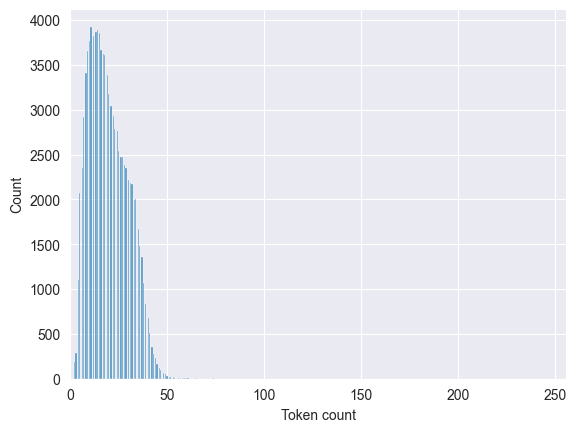

In [2]:
# X (input), y (output)
X = df['tweet']
y = df['label']

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.tweet:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
# plot the distribution of review lengths 
sns.histplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

In [3]:
# tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X_tokenized = [tokenizer(text, padding='max_length', max_length = 120, truncation=True)['input_ids'] for text in X]
X_tokenized = np.array(X_tokenized, dtype='int32')

# Train set size (80%) test set size (20%)
X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(80000, 120) (20000, 120)


In [4]:
# Get Bert layer
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [7]:
# input ids for Bert layer
input_ids_in = layers.Input(shape=(120,), name='input_token', dtype='int32')

x = dbert(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(5, activation='softmax', name='classification')(x)

model = models.Model(inputs=input_ids_in, outputs = x, name='ClassificationModelTF')

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=[metrics.SparseCategoricalAccuracy()])
model.summary()

Model: "ClassificationModelTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 120)]             0         
                                                                 
 tf_distil_bert_model (TFDi  multiple                  66362880  
 stilBertModel)                                                  
                                                                 
 tf.__operators__.getitem_1  (None, 768)               0         
  (SlicingOpLambda)                                              
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 classification (Dense)      (None, 5)       

In [9]:
# Train the model
start_time = datetime.now()
history = model.fit(X_train, y_train, batch_size=32, shuffle=True, epochs=2, validation_data=(X_test, y_test))
end_time = datetime.now()

training_time_tf = (end_time - start_time).total_seconds()
print('Training completed')

Epoch 1/2
2500/2500 [==============================] - 3079s 1s/step - loss: 0.6727 - sparse_categorical_accuracy: 0.5795 - val_loss: 0.6493 - val_sparse_categorical_accuracy: 0.5928
Epoch 2/2
2500/2500 [==============================] - 3056s 1s/step - loss: 0.6616 - sparse_categorical_accuracy: 0.5985 - val_loss: 0.6259 - val_sparse_categorical_accuracy: 0.6649
Training completed


In [10]:
#accuracy_tf = history.history['val_sparse_categorical_accuracy'][-1]
print('Training accuracy: {:.1%}'.format(history.history['sparse_categorical_accuracy'][-1]))
print('Validation accuracy: {:.1%}'.format(history.history['val_sparse_categorical_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_tf, training_time_tf/60))

Training accuracy: 59.8%
Validation accuracy: 66.5%
Training time: 6135.0s (or 102.2 minutes)


In [11]:
save_as = 'distilBERT_tf_epoch2'

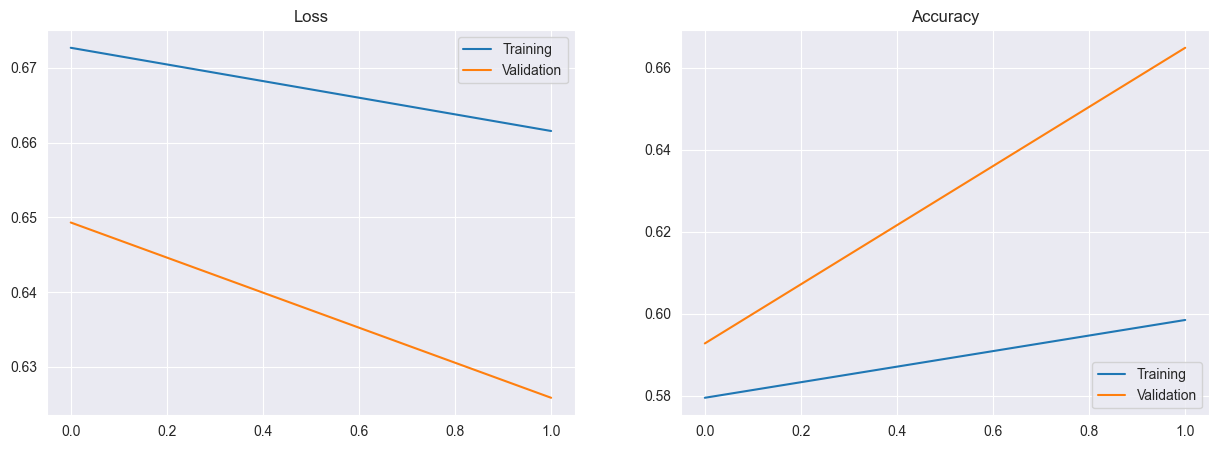

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['sparse_categorical_accuracy'], label='Training')
ax[1].plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

plt.savefig(r'C:\Users\Senju\Documents\_Solent\_Dissertation\final_report\diagrams\\' + save_as + '.png')

save_as = save_as + '.keras'

In [20]:
# save trained model
model.save(save_as, save_format='keras')

C:\Users\Senju\Documents\_Solent\_Dissertation\dissertation5\.venv\lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [28]:
# load existing model
from tensorflow.keras import models
from transformers import DistilBertConfig, TFDistilBertModel

def load_exist_model(MODEL_NAME):
    config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
    dbert_tf = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)
    loaded_model = models.load_model(MODEL_NAME, custom_objects={'TFDistilBertModel': dbert_tf})
    return loaded_model

In [29]:
model2 = load_exist_model('distilBERT_tf_shape40k_batch32_epoch1.keras')
model2.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "ClassificationModelTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 512)]             0         
                                                                 
 tf_distil_bert_model_5 (TF  TFBaseModelOutput(last_   66362880  
 DistilBertModel)            hidden_state=(None, 512             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem_2  (None, 768)               0         
  (SlicingOpLambda)                                              
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                             